In [46]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders

 
# Predicting Steph Curry's Shots 🏀

For this project, I am using a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

I will be creating a model to predict whether Curry will make a shot based on his past perfomance.

In [47]:
#Imports

import pandas as pd
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

# I. EDA and Wrangling Data 

In [48]:
'''Importing DataFrame `df`'''


url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url,
                 parse_dates=['game_date'],
                 index_col=['game_date'])

df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0


In [49]:
df.shape

(13958, 19)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13958 entries, 2009-10-28 to 2019-06-05
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   game_id                  13958 non-null  int64  
 1   game_event_id            13958 non-null  int64  
 2   player_name              13958 non-null  object 
 3   period                   13958 non-null  int64  
 4   minutes_remaining        13958 non-null  int64  
 5   seconds_remaining        13958 non-null  int64  
 6   action_type              13958 non-null  object 
 7   shot_type                13958 non-null  object 
 8   shot_zone_basic          13958 non-null  object 
 9   shot_zone_area           13958 non-null  object 
 10  shot_zone_range          13958 non-null  object 
 11  shot_distance            13958 non-null  int64  
 12  loc_x                    13958 non-null  int64  
 13  loc_y                    13958 non-null  int64  
 14  shot_

In [51]:
'''Creating new features'''

# Total seconds remaining in the period
df['seconds_remaining_period'] = df['minutes_remaining']* 60 + df['seconds_remaining']

# Whether Golden State Warriors were playing at home or away
df['home_game'] = (df['htm'] == 'GSW').astype(int)


In [52]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,...,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,seconds_remaining_period,home_game
game_date,,,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),...,26,99,249,0,GSW,HOU,Regular Season,2.0,685,1
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,18,-122,145,1,GSW,HOU,Regular Season,0.0,571,1
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),...,14,-60,129,0,GSW,HOU,Regular Season,-4.0,362,1
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),...,19,-172,82,0,GSW,HOU,Regular Season,-4.0,589,1
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,16,-68,148,0,GSW,HOU,Regular Season,0.0,139,1


In [53]:
'''Dropping columns that do not add value to the analysis.  There is only one player, and seconds_remaining_period includes both minutes_remaining and seconds_remaining.
Shot zone range and shot distance are highly correlated. Game and game event ids will be unique to each game and therefore shouldn't be used to train our model.'''

cols_to_drop = ['player_name', 'minutes_remaining', 'seconds_remaining', 'shot_zone_range', 'game_id', 'game_event_id', 'htm', 'vtm']
df = df.drop(columns=cols_to_drop)

In [54]:
df.sample(5)

,period,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_distance,loc_x,loc_y,shot_made_flag,season_type,scoremargin_before_shot,seconds_remaining_period,home_game
game_date,,,,,,,,,,,,,
2015-11-04,3,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),26,163,203,0,Regular Season,2.0,155,1
2016-03-29,1,Pullup Jump shot,3PT Field Goal,Above the Break 3,Center(C),25,42,247,1,Regular Season,0.0,699,1
2011-01-03,4,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),2,-19,15,1,Regular Season,-18.0,157,0
2016-12-11,2,Finger Roll Layup Shot,2PT Field Goal,Restricted Area,Center(C),1,-11,16,1,Regular Season,-0.0,19,0
2018-12-22,2,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),28,-136,254,1,Regular Season,-5.0,588,1


# II. Split Data

We will divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. The target is `'shot_made_flag'`.

In [55]:
'''. Create `X` and `y`.'''

target = 'shot_made_flag'
X = df.drop(columns=target)
y = df[target]

Dividing the dataset into training, validation, and test sets. 

- Training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the end of the 2016-17 season.
- Validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.

- **Note:** The NBA season begins in October and ends in June.

In [56]:
mask1 = X.index < '2017-07-01'
X_train, y_train = X.loc[mask1], y.loc[mask1]

X_val_and_test, y_val_and_test = X.loc[~mask1], y.loc[~mask1]

mask2 = X_val_and_test.index > '2018-07-01'
X_test, y_test = X_val_and_test.loc[mask2], y_val_and_test.loc[mask2]

X_val, y_val = X_val_and_test.loc[~mask2], y_val_and_test.loc[~mask2]

# III. Establishing Baseline

In [57]:
'''Calculating baseline accuracy'''

baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5272087356736757


# IV. Building a Model

In [58]:
'''Building a pipeline model with encoder and tree-based predictor.'''

model = make_pipeline(
    OrdinalEncoder(),
    #SimpleImputer(), - no null values to impute
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'season_type'],
                                mapping=[{'col': 'action_type',
                                          'data_type': dtype('O'),
                                          'mapping': Jump Shot                              1
Step Back Jump shot                    2
Pullup Jump shot                       3
Layup Shot                             4
Jump Bank Shot                         5
Driving Layup Shot                     6
Reverse Layup Shot                     7
Running Jump Shot                      8
Floating Jump shot                     9
Driving Finger Roll Layup Sho...
dtype: int64},
                                         {'col': 'shot_zone_area',
                                          'data_type': dtype('O'),
                                          'mapping': Right Side Center(RC)    1
Left Side Center(LC)     2
Center(C)                3
Left Side(L)             4
Right Side(R)            5
Back Court(BC)           6
NaN                     -2
dtype: int64},
                                         {'col': 'season_type',
                                          'data_type': dtype('O'),
                                          'mapping': Regular Season    1
Playoffs          2
NaN              -2
dtype: int64}])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

# V. Checking Metrics

In [59]:
'''Calculating train and test accuracy.'''

train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)
print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 1.0
Validation Accuracy Score: 0.5924657534246576


The model appears to be overfitting.  We will tune the model to see if we can improve it.

In [60]:
feature_imp = model.named_steps.randomforestclassifier.feature_importances_
feature_names = model.named_steps.randomforestclassifier.feature_names_in_
feat_series = pd.Series(feature_imp, index=feature_names)
feat_series.sort_values(ascending=False)

seconds_remaining_period    0.185298
loc_x                       0.161985
loc_y                       0.157593
scoremargin_before_shot     0.145893
action_type                 0.135041
shot_distance               0.083283
period                      0.056164
home_game                   0.022305
shot_zone_area              0.019539
season_type                 0.015499
shot_zone_basic             0.012852
shot_type                   0.004547
dtype: float64

# VI. Tuning Model

Using training and validation sets as a guide, we will tune the hyperparameters of our model to see if we can improve its accuracy.



In [61]:
param_grid = {
    'randomforestclassifier__max_depth' : range(10, 40, 3),
    'randomforestclassifier__n_estimators' : range(25, 150, 25)
}

In [62]:
model_rs = RandomizedSearchCV(
    model,
    param_distributions= param_grid,
    n_jobs = -1,
    n_iter = 5,
    verbose = 1,
    cv = 5
);

model_rs.fit(X_train, y_train);

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [63]:
test_acc = model_rs.score(X_test, y_test)
print('Testing Accuracy Score:', test_acc)

Testing Accuracy Score: 0.6278525453481568


# VII. Communication

Plotting confusion matrix for the model

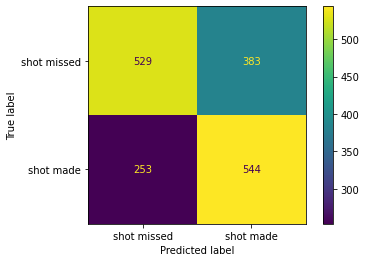

In [64]:
ConfusionMatrixDisplay.from_estimator(
    model_rs,
    X_test,
    y_test,
    values_format = '.0f',
    display_labels = ['shot missed', 'shot made']
);

Although the accuracy has improved, the model is not able to confidently predict whether Steph Curry will make the shot.